# 머신 러닝 교과서 3판

# 3장 - 사이킷런을 타고 떠나는 머신 러닝 분류 모델 투어

**아래 링크를 통해 이 노트북을 주피터 노트북 뷰어(nbviewer.jupyter.org)로 보거나 구글 코랩(colab.research.google.com)에서 실행할 수 있습니다.**

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://nbviewer.org/github/rickiepark/python-machine-learning-book-3rd-edition/blob/master/ch03/ch03.ipynb"><img src="https://jupyter.org/assets/share.png" width="60" />주피터 노트북 뷰어로 보기</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/python-machine-learning-book-3rd-edition/blob/master/ch03/ch03.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩(Colab)에서 실행하기</a>
  </td>
</table>

### 목차

- 사이킷런 첫걸음: 퍼셉트론 훈련
- 로지스틱 회귀를 사용한 클래스 확률 모델링
  - 로지스틱 회귀의 이해와 조건부 확률
  - 로지스틱 비용 함수의 가중치 학습
  - 아달린 구현을 로지스틱 회귀 알고리즘으로 변경
  - 사이킷런을 사용하여 로지스틱 회귀 모델 훈련
  - 규제를 사용하여 과대적합 피하기
- 서포트 벡터 머신을 사용한 최대 마진 분류
  - 최대 마진
  - 슬랙 변수를 사용하여 비선형 분류 문제 다루기
  - 사이킷런의 다른 구현
- 커널 SVM을 사용하여 비선형 문제 풀기
  - 선형적으로 구분되지 않는 데이터를 위한 커널 방법
  - 커널 기법을 사용하여 고차원 공간에서 분할 초평면 찾기
- 결정 트리 학습
  - 정보 이득 최대화: 자원을 최대로 활용
  - 결정 트리 만들기
  - 랜덤 포레스트로 여러 개의 결정 트리 연결
- k-최근접 이웃: 게으른 학습 알고리즘

<br>

In [ ]:
from IPython.display import Image

# 3.2 사이킷런 첫걸음

사이킷런에서 붓꽃 데이터셋을 적재합니다. 세 번째 열은 꽃잎의 길이이고 네 번째 열은 꽃잎의 너비입니다. 클래스는 이미 정수 레이블로 변환되어 있습니다. 0=Iris-Setosa, 1=Iris-Versicolor, 2=Iris-Virginica 입니다.

In [ ]:
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

print('클래스 레이블:', np.unique(y))

클래스 레이블: [0 1 2]


70%는 훈련 데이터 30%는 테스트 데이터로 분할합니다(계층화):

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

In [ ]:
print('y의 레이블 카운트:', np.bincount(y))
print('y_train의 레이블 카운트:', np.bincount(y_train))
print('y_test의 레이블 카운트:', np.bincount(y_test))

y의 레이블 카운트: [50 50 50]
y_train의 레이블 카운트: [35 35 35]
y_test의 레이블 카운트: [15 15 15]


특성을 표준화합니다:

In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

`Perceptron`은 `SGDClassifier(loss='perceptron')`과 거의 비슷합니다.

퍼셉트론 손실 : $J(\boldsymbol{w})=\begin{cases}-z^{(i)}y^{(i)}&z^{(i)}y^{(i)}\le0\mbox{ 일 때} \\ 0&\mbox{그 외}\end{cases}$
$\;\;\;\;\;$

그레이디언트 : $\mathit\Delta \boldsymbol{w}=\begin{cases}-\eta y^{(i)}\boldsymbol{x}^{(i)}&z^{(i)}y^{(i)}\le0\mbox{ 일 때} \\ 0&\mbox{그 외}\end{cases}$
$\;\;\;\;\;$

In [ ]:
from sklearn.linear_model import Perceptron

ppn = Perceptron(eta0=0.1, random_state=1)
ppn.fit(X_train_std, y_train)

Perceptron(eta0=0.1, random_state=1)

**노트**

- 사이킷런 0.19부터 `Perceptron`과 `SGDClassifier`의 반복 횟수를 지정하는 매개변수가 `n_iter`에서 `max_iter`로 변경되었습니다.

In [ ]:
y_pred = ppn.predict(X_test_std)
print('잘못 분류된 샘플 개수: %d' % (y_test != y_pred).sum())

잘못 분류된 샘플 개수: 1


In [ ]:
from sklearn.metrics import accuracy_score

print('정확도: %.3f' % accuracy_score(y_test, y_pred))

정확도: 0.978


In [ ]:
print('정확도: %.3f' % ppn.score(X_test_std, y_test))

정확도: 0.978


In [ ]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # 마커와 컬러맵을 설정합니다.
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # 결정 경계를 그립니다.
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=cl,
                    edgecolor=None if idx==1 else 'black')

    # 테스트 샘플을 부각하여 그립니다.
    if test_idx:
        # 모든 샘플을 그립니다.
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    facecolor='none',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100,
                    label='test set')

모델이 찾은 결정 경계와 산점도:

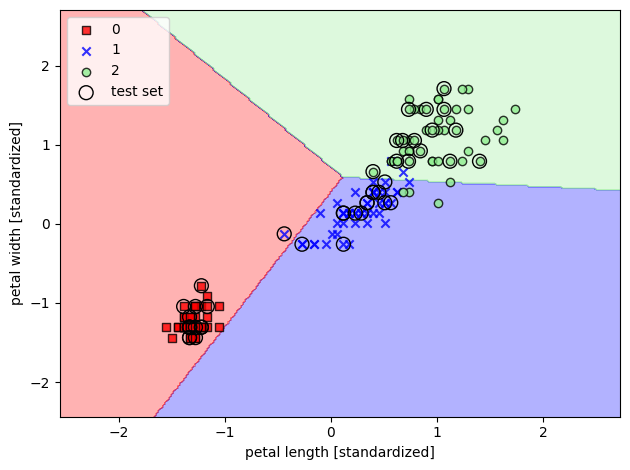

In [ ]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X=X_combined_std, y=y_combined,
                      classifier=ppn, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
# plt.savefig('images/03_01.png', dpi=300)
plt.show()

<br>

# 3.3 로지스틱 회귀를 사용한 클래스 확률 모델링

## 3.3.1 로지스틱 회귀의 이해와 조건부 확률

오즈비(특정 이벤트가 발생할 확률) $=\dfrac{P}{1-P}$ , ($P$는 양성 샘플에 대한 확률)

로짓 함수 : $logit(P)=log\dfrac{P}{1-P}$

$0\le P \le 1$이면, $0 \le \dfrac{P}{1-P} \le \infty$이고, $-\infty \le log\dfrac{P}{1-P} \le \infty$이므로

$log\dfrac{P}{1-P}=\boldsymbol{w}^T\boldsymbol{x}$처럼 쓸 수 있다.

따라서 양성 샘플일 확률 $P = \dfrac{1}{1+e^{-\boldsymbol{w}^T\boldsymbol{x}}}=\dfrac{1}{1+e^{-z}}$

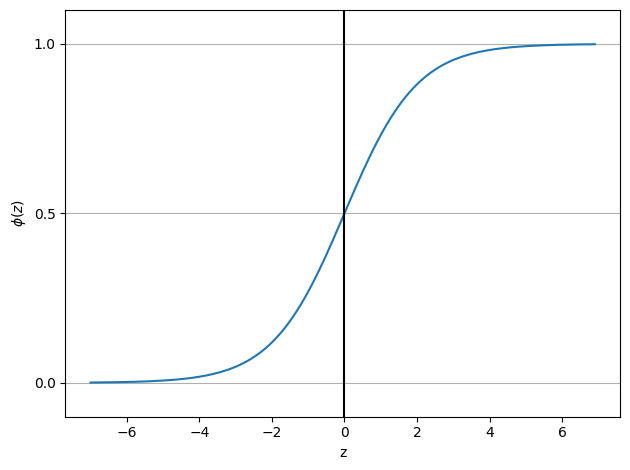

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

z = np.arange(-7, 7, 0.1)
phi_z = sigmoid(z)

plt.plot(z, phi_z)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\phi (z)$')

# y 축의 눈금과 격자선
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)

plt.tight_layout()
# plt.savefig('images/03_02.png', dpi=300)
plt.show()

In [ ]:
Image(url='https://git.io/Jtm22', width=500)

예측 확률 : $\hat{y}=\begin{cases}1&\phi(z)\ge 0.5\mbox{ 일 때} \\ 0&\mbox{그 외}\end{cases}$
$\;\;\;\;\;$
$\hat y=\begin{cases}1&z\ge 0\mbox{ 일 때} \\ 0&\mbox{그 외}\end{cases}$

<br>

## 3.3.2 로지스틱 비용 함수의 가중치 학습하기

가능도 : $L(\boldsymbol w)=\prod^n_{i=1}\phi(z^{(i)})^{y^{(i)}}\left(1-\phi(z^{(i)})\right)^{1-y^{(i)}}$

로그 가능도 : $\text{log} L(\boldsymbol w)=\sum^n_{i=1}\left[y^{(i)}\text{log}\phi(z^{(i)})+(1-y^{(i)})\text{log}\left(1-\phi(z^{(i)})\right)\right]$

로지스틱 비용 함수 : $J(\boldsymbol w)=-\sum^n_{i=1}\left[y^{(i)}\text{log}\phi(z^{(i)})+(1-y^{(i)})\text{log}\left(1-\phi(z^{(i)})\right)\right]$

손실 계산 : $J(\boldsymbol w)=\begin{cases}-\text{log}\phi(z)&y=1\mbox{ 일 때} \\ -\text{log}(1-\phi(z))&y=0\mbox{일 때}\end{cases}$

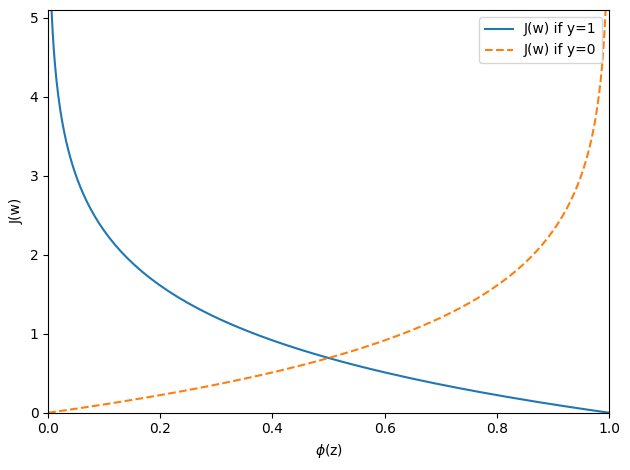

In [ ]:
def cost_1(z):
    return - np.log(sigmoid(z))


def cost_0(z):
    return - np.log(1 - sigmoid(z))

z = np.arange(-10, 10, 0.1)
phi_z = sigmoid(z)

c1 = [cost_1(x) for x in z]
plt.plot(phi_z, c1, label='J(w) if y=1')

c0 = [cost_0(x) for x in z]
plt.plot(phi_z, c0, linestyle='--', label='J(w) if y=0')

plt.ylim(0.0, 5.1)
plt.xlim([0, 1])
plt.xlabel('$\phi$(z)')
plt.ylabel('J(w)')
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('images/03_04.png', dpi=300)
plt.show()

<br>

## 3.3.3 아달린 구현을 로지스틱 회귀 알고리즘으로 변경

로지스틱 손실 함수의 미분 :

$\begin{align*}
\dfrac{\partial}{\partial w_j}J(\boldsymbol w)&=-\dfrac{\partial}{\partial w_j}\left[y^{(i)}\text{log}\phi(z^{(i)})+(1-y^{(i)})\text{log}\left(1-\phi(z^{(i)})\right)\right] \\
&=-y^{(i)}\dfrac{\partial}{\partial w_j}\text{log}\phi(z^{(i)})-(1-y^{(i)})\dfrac{\partial}{\partial w_j}\text{log}\left(1-\phi(z^{(i)})\right) \\
&=-y^{(i)}\dfrac{1}{\phi(z^{(i)})}\dfrac{\partial}{\partial w_j}\phi(z^{(i)})+(1-y^{(i)})\dfrac{1}{\left(1-\phi(z^{(i)})\right)}\dfrac{\partial}{\partial w_j}\phi(z^{(i)}) \\
&=\left(-y^{(i)}\dfrac{1}{\phi(z^{(i)})}+(1-y^{(i)})\dfrac{1}{\left(1-\phi(z^{(i)})\right)}\right)\dfrac{\partial}{\partial w_j}\phi(z^{(i)}) \\
\end{align*}$

시그모이드 함수를 z에 대해 미분하면 :

$\dfrac{\partial}{\partial z}\phi(z)=\dfrac{\partial}{\partial z}\left(\dfrac{1}{1+e^{-z}}\right)=-\dfrac{1}{(1+e^{-z})^2}(-e^{-z})=\dfrac{1+e^{-z}-1}{(1+e^{-z})^2}=\dfrac{1+e^{-z}}{(1+e^{-z})^2}-\dfrac{1}{(1+e^{-z})^2}=\dfrac{1}{1+e^{-z}}\left(1-\dfrac{1}{1+e^{-z}}\right)=\phi(z)(1-\phi(z))$

따라서,

$\begin{align*}
\dfrac{\partial}{\partial w_j}J(\boldsymbol w)&=\left(-y^{(i)}\dfrac{1}{\phi(z^{(i)})}+(1-y^{(i)})\dfrac{1}{\left(1-\phi(z^{(i)})\right)}\right)\phi(z^{(i)})\left(1-\phi(z^{(i)})\right)\dfrac{\partial}{\partial w_j}z^{(i)} \\
&=\left(-y^{(i)}\left(1-\phi(z^{(i)})\right)+(1-y^{(i)})\phi(z^{(i)})\right)x_j^{(i)}\\
&=\left(-y^{(i)}+y^{(i)}\phi(z^{(i)})+\phi(z^{(i)})-y^{(i)}\phi(z^{(i)})\right)x_j^{(i)}\\
&=-\left(y^{(i)}-\phi(z^{(i)})\right)x_j^{(i)}
\end{align*}$

In [ ]:
class LogisticRegressionGD(object):
    """경사 하강법을 사용한 로지스틱 회귀 분류기

    매개변수
    ------------
    eta : float
      학습률 (0.0과 1.0 사이)
    n_iter : int
      훈련 데이터셋 반복 횟수
    random_state : int
      가중치 무작위 초기화를 위한 난수 생성기 시드

    속성
    -----------
    w_ : 1d-array
      학습된 가중치
    cost_ : list
      에포크마다 누적된 로지스틱 비용 함수 값

    """
    def __init__(self, eta=0.05, n_iter=100, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """훈련 데이터 학습

        매개변수
        ----------
        X : {array-like}, shape = [n_samples, n_features]
          n_samples 개의 샘플과 n_features 개의 특성으로 이루어진 훈련 데이터
        y : array-like, shape = [n_samples]
          타깃값

        반환값
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()

            # 오차 제곱합 대신 로지스틱 비용을 계산합니다.
            cost = -y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output)))
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        """최종 입력 계산"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, z):
        """로지스틱 시그모이드 활성화 계산"""
        # 대신 from scipy.special import expit; expit(z) 을 사용할 수 있습니다.
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def predict(self, X):
        """단위 계단 함수를 사용하여 클래스 레이블을 반환합니다"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)
        # 다음과 동일합니다.
        # return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

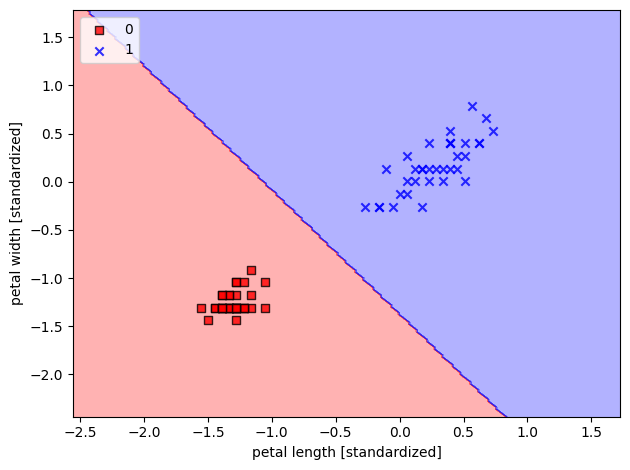

In [ ]:
X_train_01_subset = X_train_std[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]

lrgd = LogisticRegressionGD(eta=0.05, n_iter=1000, random_state=1)
lrgd.fit(X_train_01_subset,
         y_train_01_subset)

plot_decision_regions(X=X_train_01_subset,
                      y=y_train_01_subset,
                      classifier=lrgd)

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
# plt.savefig('images/03_05.png', dpi=300)
plt.show()

<br>

## 3.3.4 사이킷런을 사용해 로지스틱 회귀 모델 훈련하기

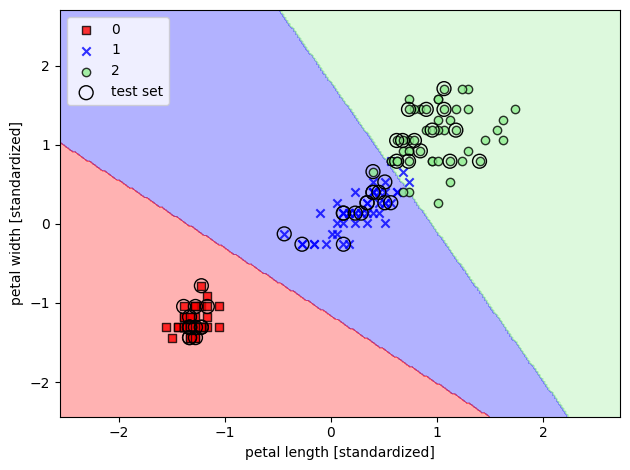

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=100.0, random_state=1)
lr.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined,
                      classifier=lr, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('images/03_06.png', dpi=300)
plt.show()

In [ ]:
lr.predict_proba(X_test_std[:3, :])

array([[1.52213484e-12, 3.85303417e-04, 9.99614697e-01],
       [9.93560717e-01, 6.43928295e-03, 1.14112016e-15],
       [9.98655228e-01, 1.34477208e-03, 1.76178271e-17]])

In [ ]:
lr.predict_proba(X_test_std[:3, :]).sum(axis=1)

array([1., 1., 1.])

In [ ]:
lr.predict_proba(X_test_std[:3, :]).argmax(axis=1)

array([2, 0, 0])

In [ ]:
lr.predict(X_test_std[:3, :])

array([2, 0, 0])

In [ ]:
lr.predict(X_test_std[0, :].reshape(1, -1))

array([2])

<br>

## 3.3.5 규제를 사용해 과대적합 피하기

In [ ]:
Image(url='https://git.io/Jtm2V', width=700)

L2 규제(L2 노름의 제곱) : $\lVert\boldsymbol{w}\rVert^2_2=\sum_{j=1}^m w_j^2$

L1 규제(L1 노름) : $\lVert\boldsymbol{w}\rVert_1=\sum_{j=1}^m \left|w_j\right|$

규제가 추가된 비용 함수 : $J(\boldsymbol w)=-\sum^n_{i=1}\left[y^{(i)}\text{log}\phi(z^{(i)})+(1-y^{(i)})\text{log}\left(1-\phi(z^{(i)})\right)\right]+\dfrac{\lambda}{2}\sum_{j=1}^m w_j^2$

- `C`는 $\lambda$의 역수로 증가시키면 규제가 작아지고, 감소시키면 규제가 커짐. 기본값은 1.0

- 규제가 작다 - 가중치의 영향 크다

- `penalty` 매개변수 기본값 `'l2'`, L1 규제를 위해 `'l1'`을 지정할 수 있음.

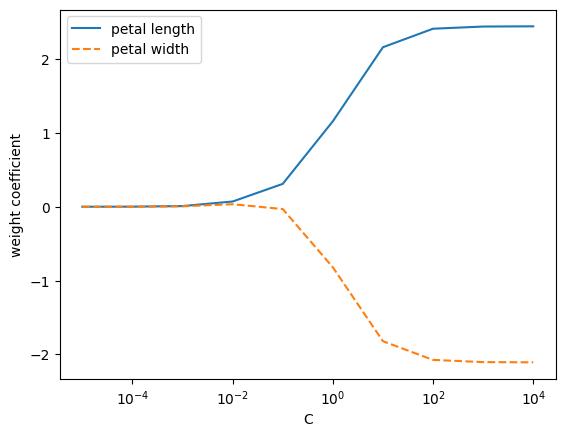

In [ ]:
weights, params = [], []
for c in np.arange(-5, 5):
    lr = LogisticRegression(C=10.**c, random_state=1, multi_class='ovr')
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10.**c)

weights = np.array(weights)
plt.plot(params, weights[:, 0],
         label='petal length')
plt.plot(params, weights[:, 1], linestyle='--',
         label='petal width')
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
# plt.savefig('images/03_08.png', dpi=300)
plt.show()

<br>

C의 따른 가중치 변화, C가 커지면 규제가 풀어지며 가중치가 커진다

# 3.4 서포트 벡터 머신을 사용한 최대 마진 분류

In [ ]:
Image(url='https://git.io/Jtm2r', width=700)

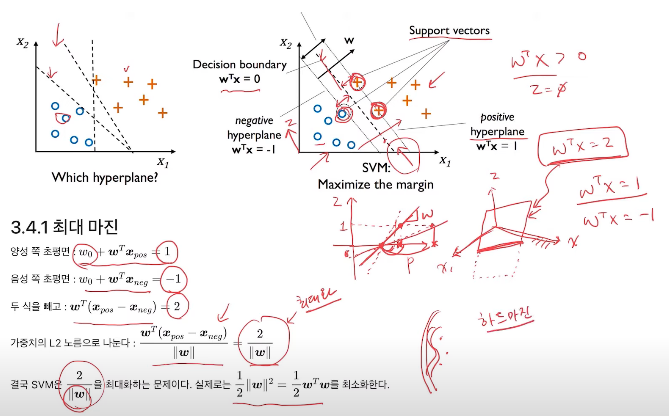

## 3.4.1 최대 마진

양성 쪽 초평면 : $w_0+\boldsymbol{w}^T\boldsymbol{x}_{pos}=1$

음성 쪽 초평면 : $w_0+\boldsymbol{w}^T\boldsymbol{x}_{neg}=-1$

두 식을 빼고 : $\boldsymbol{w}^T(\boldsymbol{x}_{pos}-\boldsymbol{x}_{neg})=2$

가중치의 L2 노름으로 나눈다 : $\dfrac{\boldsymbol{w}^T(\boldsymbol{x}_{pos}-\boldsymbol{x}_{neg})}{\lVert \boldsymbol w \rVert}=\dfrac{2}{\lVert \boldsymbol w \rVert}$

**결국 SVM은 $\dfrac{2}{\lVert \boldsymbol w \rVert}$을 최대화하는 문제이다. 실제로는 $\dfrac{1}{2}\lVert \boldsymbol w \rVert^2=\dfrac{1}{2}\boldsymbol w^T \boldsymbol w$를 최소화한다.**

## 3.4.2 슬랙 변수를 사용하여 비선형 분류 문제 다루기

제타 = 슬랙변수, 제타만큼의 오차, 여유를 준다?

양성 샘플일 때 : $w_0+\boldsymbol w^T \boldsymbol x^{(i)} \ge 1-\zeta^{(i)}$

음성 샘플일 때 : $w_0+\boldsymbol w^T \boldsymbol x^{(i)} \le -1+\zeta^{(i)}$

목적 함수 : $\dfrac{1}{2} \boldsymbol w^T \boldsymbol w+C\sum_i \zeta^{(i)}$

C가 커지면 - 규제가 작아짐. 복잡한 모델, 좁은마진

C가 작아지면 - 규제가 커짐. 마진 오류가 생기더라도 가중치가 적어져서 단순한모델, 넓은 마진

In [ ]:
Image(url='https://git.io/Jtm26', width=600)

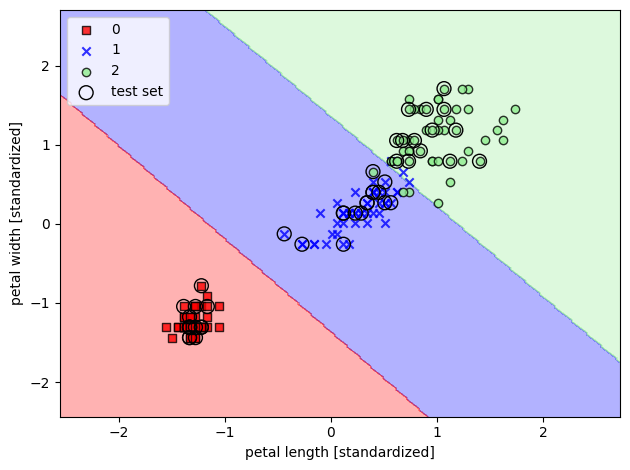

In [ ]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', C=1.0, random_state=1)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std,
                      y_combined,
                      classifier=svm,
                      test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('images/03_11.png', dpi=300)
plt.show()

## 3.4.3 사이킷런의 다른 구현
확률적 경사하강을 활용하고 싶을 경우 손실함수를 hinge로 설정하면 svm을 확률적 경사하강을 통해 사용가능

In [ ]:
from sklearn.linear_model import SGDClassifier

ppn = SGDClassifier(loss='perceptron')
# 사이킷런 1.3버전을 사용하는 경우 'log'를 'log_loss'로 바꾸어 사용하세요.
lr = SGDClassifier(loss='log')
svm = SGDClassifier(loss='hinge')

<br>

# 3.5 커널 SVM을 사용하여 비선형 문제 풀기

## 3.5.1 선형적으로 구분되지 않는 데이터를 위한 커널 방법

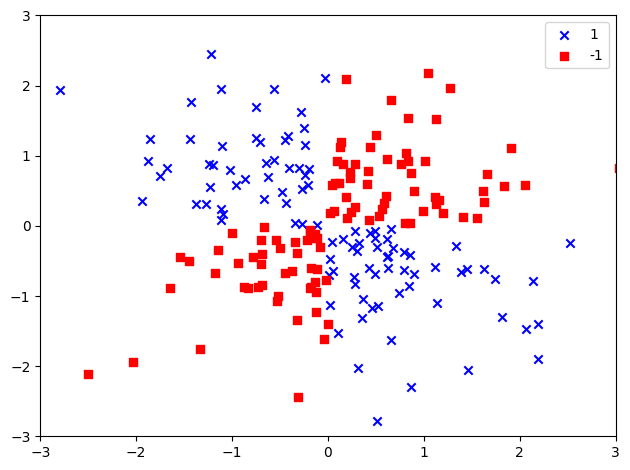

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1)
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0,
                       X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, -1)

plt.scatter(X_xor[y_xor == 1, 0],
            X_xor[y_xor == 1, 1],
            c='b', marker='x',
            label='1')
plt.scatter(X_xor[y_xor == -1, 0],
            X_xor[y_xor == -1, 1],
            c='r',
            marker='s',
            label='-1')

plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('images/03_12.png', dpi=300)
plt.show()

3차원으로 변환, 제곱합 추가를 통해

$\phi(x_1, x_2)=(x_1, x_2, x_1^2+x_2^2)$

In [ ]:
Image(url='https://git.io/Jtm2X', width=700)
#커널 svm

<br>

## 3.5.2 커널 기법을 사용해 고차원 공간에서 분할 초평면 찾기
실제로 차원이 늘어나는것은 아님 - 커널 함수

커널함수 종류
- 방사기저함수
- 하이퍼 볼릭 탄젠트 함수 사용 하는 sigmoid 커널
- 다항 함수로 표현되는 poly 커널

rdf 감마가 커지면 과적합

방사 기저 함수(Radial Basis Function) : $K(\boldsymbol x^{(i)}, \boldsymbol x^{(j)})=\text{exp}\left(-\dfrac{1}{2\sigma^2}\lVert \boldsymbol x^{(i)}-\boldsymbol x^{(j)} \rVert^2\right)=\text{exp}\left( -\gamma\lVert \boldsymbol x^{(i)}-\boldsymbol x^{(j)} \rVert^2 \right)$

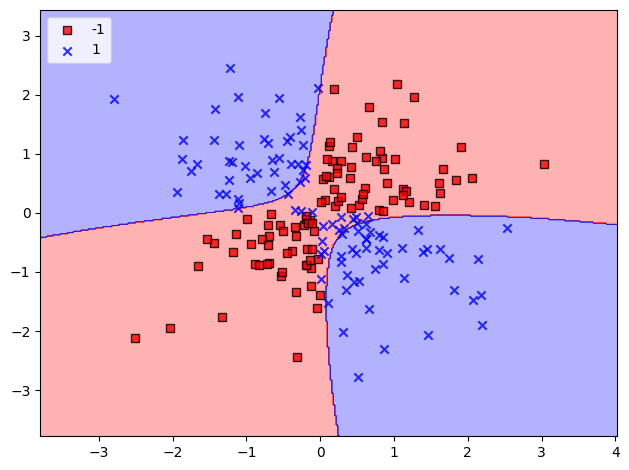

In [ ]:
svm = SVC(kernel='rbf', random_state=1, gamma=0.10, C=10.0)
svm.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor,
                      classifier=svm)

plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('images/03_14.png', dpi=300)
plt.show()

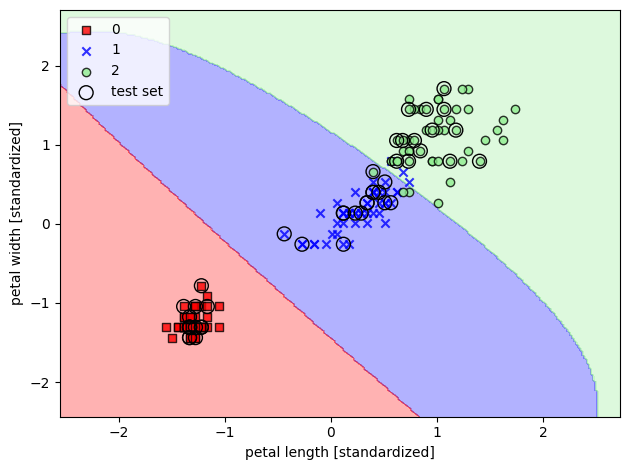

In [ ]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', random_state=1, gamma=0.2, C=1.0)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined,
                      classifier=svm, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('images/03_15.png', dpi=300)
plt.show()

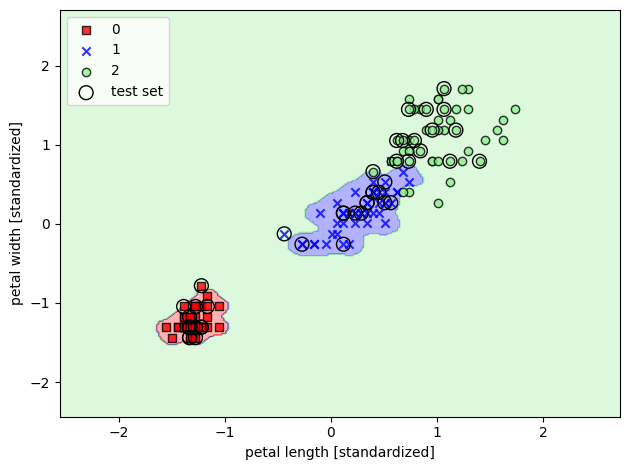

In [ ]:
svm = SVC(kernel='rbf', random_state=1, gamma=100.0, C=1.0)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined,
                      classifier=svm, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('images/03_16.png', dpi=300)
plt.show()

<br>

# 3.6 결정 트리 학습

In [ ]:
Image(url='https://git.io/Jtm21', width=500)

<br>

## **3.6.1 정보 이득 최대화 - 자원을 최대로 활용하기**

$IG = I_p - \dfrac{n_l}{n_p}I_l - \dfrac{n_r}{n_p}I_r$

In [ ]:
Image(url='https://git.io/Jtm2D', width=500)

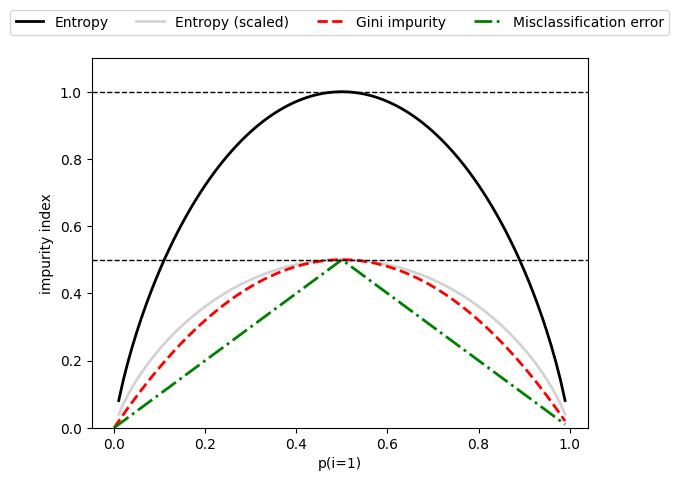

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def gini(p):
    return p * (1 - p) + (1 - p) * (1 - (1 - p))


def entropy(p):
    return - p * np.log2(p) - (1 - p) * np.log2((1 - p))


def error(p):
    return 1 - np.max([p, 1 - p])

x = np.arange(0.0, 1.0, 0.01)

ent = [entropy(p) if p != 0 else None for p in x]
sc_ent = [e * 0.5 if e else None for e in ent]
err = [error(i) for i in x]

fig = plt.figure()
ax = plt.subplot(111)
for i, lab, ls, c, in zip([ent, sc_ent, gini(x), err],
                          ['Entropy', 'Entropy (scaled)',
                           'Gini impurity', 'Misclassification error'],
                          ['-', '-', '--', '-.'],
                          ['black', 'lightgray', 'red', 'green', 'cyan']):
    line = ax.plot(x, i, label=lab, linestyle=ls, lw=2, color=c)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=5, fancybox=True, shadow=False)

ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
plt.ylim([0, 1.1])
plt.xlabel('p(i=1)')
plt.ylabel('impurity index')
# plt.savefig('images/03_19.png', dpi=300, bbox_inches='tight')
plt.show()

<br>

선형보다 지니나 엔트로피가 0으로 갈때 더 급격하게 줄어들기 때문에 잘 나눠진다

## 3.6.2 결정 트리 만들기

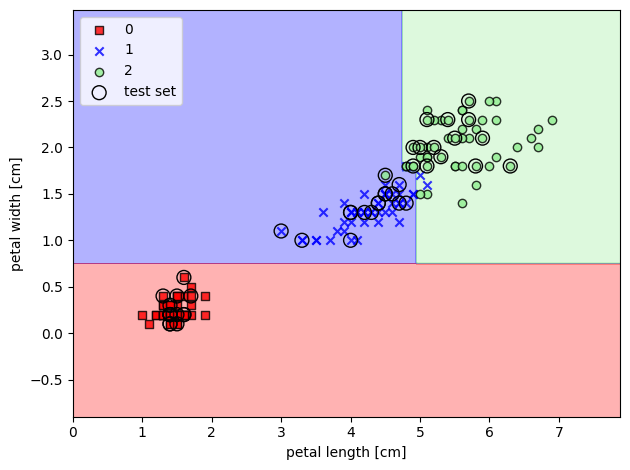

In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier(criterion='gini',
                                    max_depth=4,
                                    random_state=1)
tree_model.fit(X_train, y_train)

X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined, y_combined,
                      classifier=tree_model,
                      test_idx=range(105, 150))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('images/03_20.png', dpi=300)
plt.show()

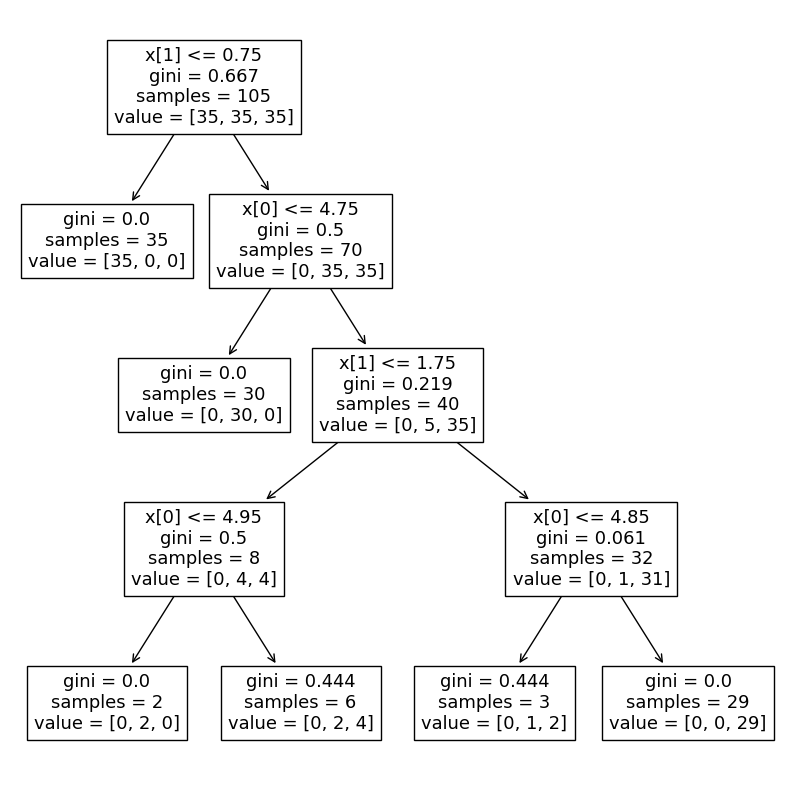

In [ ]:
from sklearn import tree

plt.figure(figsize=(10,10))
tree.plot_tree(tree_model)
plt.show()

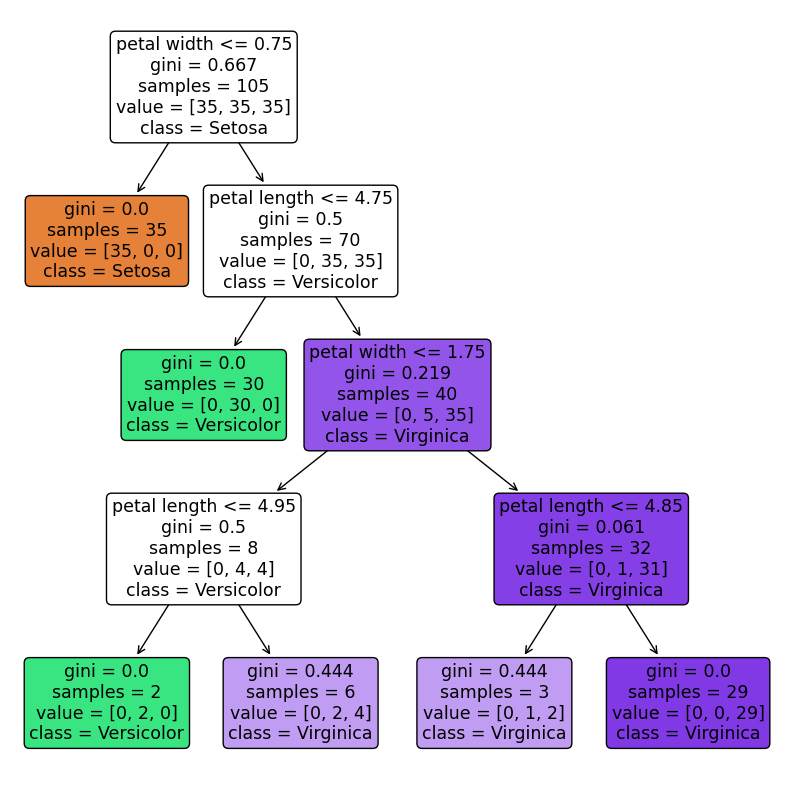

In [ ]:
plt.figure(figsize=(10,10))
tree.plot_tree(tree_model,
               impurity=True,
               filled=True,
               rounded=True,
               class_names=['Setosa',
                            'Versicolor',
                            'Virginica'],
               feature_names=['petal length',
                              'petal width'])
plt.show()

In [ ]:
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz

dot_data = export_graphviz(tree_model,
                           filled=True,
                           rounded=True,
                           class_names=['Setosa',
                                        'Versicolor',
                                        'Virginica'],
                           feature_names=['petal length',
                                          'petal width'],
                           out_file=None)
graph = graph_from_dot_data(dot_data)
graph.write_png('tree.png')

True

In [ ]:
Image(url='https://git.io/Jtm2H', width=600)

<br>

## 3.6.3 랜덤 포레스트로 여러 개의 결정 트리 연결하기
max_samples - 추출 표본 수 설정
특성의 루트갯수 사용
max_depth를 굳이 설정하지 않아도 된

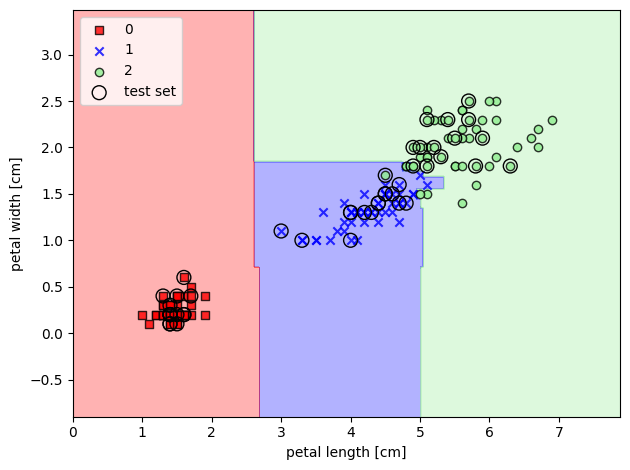

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(criterion='gini',
                                n_estimators=25,
                                random_state=1,
                                n_jobs=2)
forest.fit(X_train, y_train)

plot_decision_regions(X_combined, y_combined,
                      classifier=forest, test_idx=range(105, 150))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('images/03_22.png', dpi=300)
plt.show()

<br>

# 3.7 K-최근접 이웃: 게으른 학습 알고리즘

In [ ]:
Image(url='https://git.io/Jtm25', width=400)

p 1:맨허튼거리/2:유클리디어거리

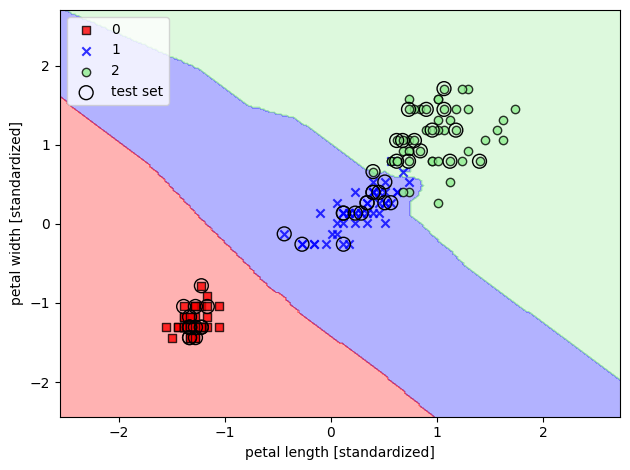

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5,
                           p=2,
                           metric='minkowski')
knn.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined,
                      classifier=knn, test_idx=range(105, 150))

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('images/03_24.png', dpi=300)
plt.show()

# 머신 러닝 교과서 3판

# 4장 - 좋은 훈련 데이터셋 만들기 – 데이터 전처리

**아래 링크를 통해 이 노트북을 주피터 노트북 뷰어(nbviewer.jupyter.org)로 보거나 구글 코랩(colab.research.google.com)에서 실행할 수 있습니다.**

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://nbviewer.org/github/rickiepark/python-machine-learning-book-3rd-edition/blob/master/ch04/ch04.ipynb"><img src="https://jupyter.org/assets/share.png" width="60" />주피터 노트북 뷰어로 보기</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/python-machine-learning-book-3rd-edition/blob/master/ch04/ch04.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩(Colab)에서 실행하기</a>
  </td>
</table>

### 목차

- 누락된 데이터 다루기
  - 테이블 형태 데이터에서 누락된 값 식별
  - 누락된 값이 있는 훈련 샘플이나 특성 제외
  - 누락된 값 대체
  - 사이킷런 추정기 API 익히기
- 범주형 데이터 다루기
  - 판다스를 사용한 범주형 데이터 인코딩
  - 순서가 있는 특성 매핑
  - 클래스 레이블 인코딩
  - 순서가 없는 특성에 원-핫 인코딩 적용
- 데이터셋을 훈련 데이터셋과 테스트 데이터셋으로 나누기
- 특성 스케일 맞추기
- 유용한 특성 선택
  - 모델 복잡도 제한을 위한 L1 규제와 L 2 규제
  - L 2 규제의 기하학적 해석
  - L1 규제를 사용한 희소성
  - 순차 특성 선택 알고리즘
- 랜덤 포레스트의 특성 중요도 사용
- 요약

<br>

In [ ]:
from IPython.display import Image

# 4.1 누락된 데이터 다루기

## 4.1.1 테이블 형태 데이터에서 누락된 값 식별

StringIO - 문자열을 csv처럼

In [ ]:
import pandas as pd
from io import StringIO
import sys

csv_data = \
'''A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0,11.0,12.0,'''

# 파이썬 2.7을 사용하는 경우
# 다음과 같이 문자열을 유니코드로 변환해야 합니다:
if (sys.version_info < (3, 0)):
    csv_data = unicode(csv_data)

df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [ ]:
df.isnull().sum()

,0
A,0
B,0
C,1
D,1


In [ ]:
# `values` 속성으로 넘파이 배열을 얻을 수 있습니다
df.values

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6., nan,  8.],
       [10., 11., 12., nan]])

<br>

## 4.1.2 누락된 값이 있는 훈련 샘플이나 특성 제외

In [ ]:
# 누락된 값이 있는 행을 삭제합니다
df.dropna(axis=0)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [ ]:
# 누락된 값이 있는 열을 삭제합니다
df.dropna(axis=1)

,A,B
0,1.0,2.0
1,5.0,6.0
2,10.0,11.0


In [ ]:
# 모든 열이 NaN인 행을 삭제합니다
df.dropna(how='all')

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [ ]:
# NaN 아닌 값이 네 개보다 작은 행을 삭제합니다
df.dropna(thresh=4)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [ ]:
# 특정 열에 NaN이 있는 행만 삭제합니다(여기서는 'C'열)
df.dropna(subset=['C'])

,A,B,C,D
0,1.0,2.0,3.0,4.0
2,10.0,11.0,12.0,NaN


<br>

## 4.1.3 누락된 값 대체

In [ ]:
# 원래 배열
df.values

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6., nan,  8.],
       [10., 11., 12., nan]])

In [ ]:
csv_data = \
'''A,B,C,D
1.0,2.0,3.0,4.0
5.0,,5.0,8.0
10.0,11.0,12.0,'''

# 파이썬 2.7을 사용하는 경우
# 다음과 같이 문자열을 유니코드로 변환해야 합니다:
if (sys.version_info < (3, 0)):
    csv_data = unicode(csv_data)

df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,NaN,5.0,8.0
2,10.0,11.0,12.0,NaN


In [ ]:
# 열의 평균으로 누락된 값 대체하기
from sklearn.impute import SimpleImputer
import numpy as np

imr = SimpleImputer(missing_values=np.nan, strategy='mean')
imr = imr.fit(df.values)
imputed_data = imr.transform(df.values)
imputed_data

array([[ 1. ,  2. ,  3. ,  4. ],
       [ 5. ,  6.5,  5. ,  8. ],
       [10. , 11. , 12. ,  6. ]])

In [ ]:
#행의 평균으로 대체 - 행렬 변환해서 평균 내고 다시 행렬 변환
from sklearn.preprocessing import FunctionTransformer

ftr_imr = FunctionTransformer(lambda X: imr.fit_transform(X.T).T)
imputed_data = ftr_imr.fit_transform(df.values)
imputed_data

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6.,  5.,  8.],
       [10., 11., 12., 11.]])

`SimpleImputer` 클래스의 `add_indicator` 매개변수를 `True`로 지정하면 `indicator_` 속성이 추가되고 `transform()` 메서드가 누락된 값의 위치를 포함된 배열을 반환합니다.

In [ ]:
imr = SimpleImputer(add_indicator=True)
imputed_data = imr.fit_transform(df.values)
imputed_data

array([[ 1. ,  2. ,  3. ,  4. ,  0. ,  0. ],
       [ 5. ,  6.5,  5. ,  8. ,  1. ,  0. ],
       [10. , 11. , 12. ,  6. ,  0. ,  1. ]])

추가된 `indicator_` 속성은 `MissingIndicator` 클래스의 객체입니다.

In [ ]:
imr.indicator_

MissingIndicator(error_on_new=False)

`MissingIndicator` 객체의 `features_` 속성은 누락된 값이 있는 특성의 인덱스를 담고 있습니다.

In [ ]:
imr.indicator_.features_

array([2, 3])

`MissingIndicator` 객체의 `fit_transform()` 메서드를 호출하면 `features_` 속성에 담긴 특성에서 누락된 값의 위치를 나타내는 배열을 반환합니다. 여기에서는 세 번째, 네 번째 특성의 누락된 값의 위치입니다. 이 배열의 값이 `SimpleImputer` 객체의 `transfrom()` 메서드가 반환한 배열의 마지막 두 열에 해당합니다.

In [ ]:
imr.indicator_.fit_transform(df.values)

array([[False, False],
       [ True, False],
       [False,  True]])

In [ ]:
# 사이킷런 0.24 버전에서 추가되었습니다.
imr.inverse_transform(imputed_data)

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6., nan,  8.],
       [10., 11., 12., nan]])

`SimpleImputer`는 한 특성의 통곗값을 사용하여 누락된 값을 채웁니다. 이와 달리 `IterativeImputer` 클래스는 다른 특성을 사용하여 누락된 값을 예측합니다. 먼저 `initial_strategy` 매개변수에 지정된 방식으로 누락된 값을 초기화합니다. 그다음 누락된 값이 있는 한 특성을 타깃으로 삼고 다른 특성을 사용해 모델을 훈련하여 예측합니다. 이런 식으로 누락된 값이 있는 모든 특성을 순회합니다.

`initial_strategy` 매개변수에 지정할 수 있는 값은 `SimpleImputer`와 동일하게 `'mean'`, `'median'`, `'most_frequent'`, `'constant'`가 가능합니다.

예측할 특성을 선택하는 순서는 누락된 값이 가장 적은 특성부터 선택하는 `'ascending'`, 누락된 값이 가장 큰 특성부터 선택하는 `'descending'`, 왼쪽에서 오른쪽으로 선택하는 `'roman'`, 오른쪽에서 왼쪽으로 선택하는 `'arabic'`, 랜덤하게 고르는 `'random'`이 있습니다. 기본값은 `'ascending'`입니다.

특성 예측은 종료 조건을 만족할 때까지 반복합니다. 각 반복 단계에서 이전 단계와 절댓값 차이 중 가장 큰 값이 누락된 값을 제외하고 가장 큰 절댓값에 `tol` 매개변수를 곱한 것보다 작을 경우 종료합니다. `tol` 매개변수 기본값은 1e-3입니다. 또는 `max_iter` 매개변수에서 지정한 횟수에 도달할 때 종료합니다. `max_iter`의 기본값은 10입니다.

예측에 사용하는 모델은 `estimator` 매개변수에서 지정할 수 있으며 기본적으로 `BayesianRidge` 클래스를 사용합니다. 예측에 사용할 특성 개수는 `n_nearest_features`에서 지정할 수 있으며 상관 계수가 높은 특성을 우선하여 랜덤하게 선택합니다. 기본값은 `None`으로 모든 특성을 사용합니다.

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

iimr = IterativeImputer()
iimr.fit_transform(df.values)

array([[ 1.        ,  2.        ,  3.        ,  4.        ],
       [ 5.        ,  6.        ,  7.00047063,  8.        ],
       [10.        , 11.        , 12.        , 12.99964527]])

`KNNImputer` 클래스는 K-최근접 이웃 방법을 사용해 누락된 값을 채웁니다. 최근접 이웃의 개수는 `n_neighbors` 매개변수로 지정하며 기본값은 5입니다. 샘플 개수가 `n_neighbors` 보다 작으면 `SimpleImputer(strategy='mean')`과 결과가 같습니다.

In [ ]:
from sklearn.impute import KNNImputer

kimr = KNNImputer()
kimr.fit_transform(df.values)

array([[ 1. ,  2. ,  3. ,  4. ],
       [ 5. ,  6. ,  7.5,  8. ],
       [10. , 11. , 12. ,  6. ]])

In [ ]:
df.fillna(df.mean())

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,7.5,8.0
2,10.0,11.0,12.0,6.0


`fillna()` 메서드의 `method` 매개변수를 사용하여 누락된 값을 채울 수도 있습니다. `bfill` 또는 `backfill`은 누락된 값을 다음 행의 값으로 채웁니다. `ffill` 또는 `pad`는 누락된 값을 이전 행의 값으로 채웁니다.

In [ ]:
df.fillna(method='bfill') # method='backfill'와 같습니다

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,12.0,8.0
2,10.0,11.0,12.0,NaN


In [ ]:
df.fillna(method='ffill') # method='pad'와 같습니다

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,3.0,8.0
2,10.0,11.0,12.0,8.0


`axis=1`로 지정하면 행이 아니라 열을 사용합니다. 예를 들어 다음처럼 지정하면 이전 열의 값으로 누락된 값을 채웁니다.

In [ ]:
df.fillna(method='ffill', axis=1)

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,6.0,8.0
2,10.0,11.0,12.0,12.0


<br>

## 4.1.4 사이킷런 추정기 API 익히기

In [ ]:
Image(url='https://git.io/Jtmwv', width=400)

In [ ]:
Image(url='https://git.io/JtYZW', width=300)

<br>

# 4.2 범주형 데이터 다루기

## 4.2.1 판다스를 사용한 범주형 데이터 인코딩

In [ ]:
import pandas as pd

df = pd.DataFrame([['green', 'M', 10.1, 'class2'],
                   ['red', 'L', 13.5, 'class1'],
                   ['blue', 'XL', 15.3, 'class2']])

df.columns = ['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class2
1,red,L,13.5,class1
2,blue,XL,15.3,class2


<br>

## 4.2.2 순서가 있는 특성 매핑

In [ ]:
size_mapping = {'XL': 3,
                'L': 2,
                'M': 1}

df['size'] = df['size'].map(size_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class2
1,red,2,13.5,class1
2,blue,3,15.3,class2


In [ ]:
inv_size_mapping = {v: k for k, v in size_mapping.items()}
df['size'].map(inv_size_mapping)

0     M
1     L
2    XL
Name: size, dtype: object

<br>

## 4.2.3 클래스 레이블 인코딩

In [ ]:
import numpy as np

# 클래스 레이블을 문자열에서 정수로 바꾸기 위해
# 매핑 딕셔너리를 만듭니다
class_mapping = {label: idx for idx, label in enumerate(np.unique(df['classlabel']))}
class_mapping

{'class1': 0, 'class2': 1}

In [ ]:
# 클래스 레이블을 문자열에서 정수로 바꿉니다
df['classlabel'] = df['classlabel'].map(class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,1
1,red,2,13.5,0
2,blue,3,15.3,1


In [ ]:
# 클래스 레이블을 거꾸로 매핑합니다
inv_class_mapping = {v: k for k, v in class_mapping.items()}
df['classlabel'] = df['classlabel'].map(inv_class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class2
1,red,2,13.5,class1
2,blue,3,15.3,class2


In [ ]:
from sklearn.preprocessing import LabelEncoder

# 사이킷런의 LabelEncoder을 사용한 레이블 인코딩
class_le = LabelEncoder()
y = class_le.fit_transform(df['classlabel'].values)
y

array([1, 0, 1])

In [ ]:
# 거꾸로 매핑
class_le.inverse_transform(y)

array(['class2', 'class1', 'class2'], dtype=object)

In [ ]:
class_le.classes_

array(['class1', 'class2'], dtype=object)

<br>

## 4.2.4 순서가 없는 특성에 원-핫 인코딩 적용

In [ ]:
X = df[['color', 'size', 'price']].values
color_le = LabelEncoder()
X[:, 0] = color_le.fit_transform(X[:, 0])
X


array([[1, 1, 10.1],
       [2, 2, 13.5],
       [0, 3, 15.3]], dtype=object)

`OrdinalEncoder`와 `ColumnTransformer` 함께 사용하기

순서없는 경우 레이블보다는 더 적절하다? /원하는 열에만 적용가능

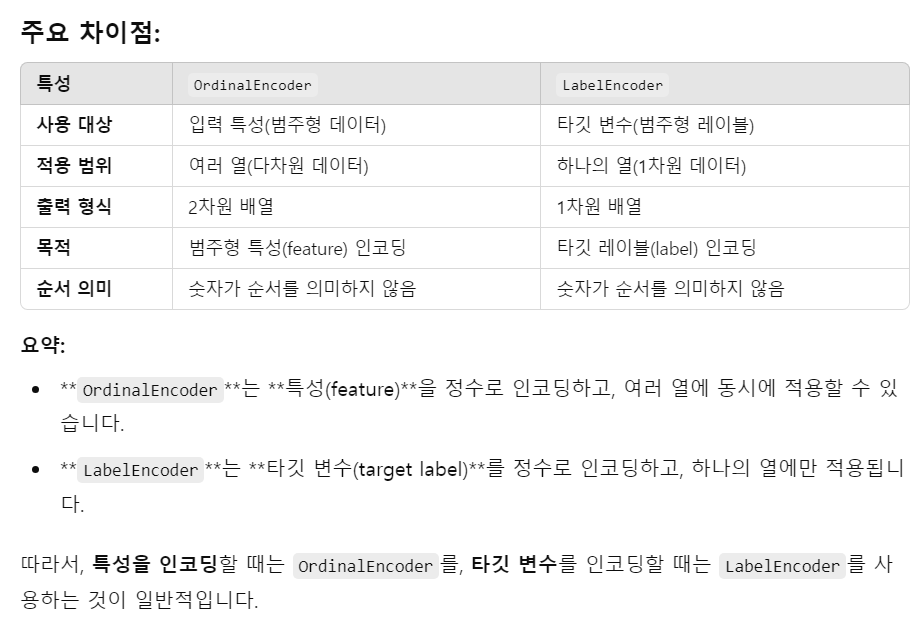

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder(dtype=int)
col_trans = ColumnTransformer([('ord_enc', ord_enc, ['color'])])
X_trans = col_trans.fit_transform(df)
X_trans

array([[1],
       [2],
       [0]])

In [ ]:
col_trans.named_transformers_['ord_enc'].inverse_transform(X_trans)

array([['green'],
       ['red'],
       ['blue']], dtype=object)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

X = df[['color', 'size', 'price']].values
color_ohe = OneHotEncoder()
color_ohe.fit_transform(X[:, 0].reshape(-1, 1)).toarray()

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [ ]:
from sklearn.compose import ColumnTransformer

X = df[['color', 'size', 'price']].values
c_transf = ColumnTransformer([ ('onehot', OneHotEncoder(), [0]),
                               ('nothing', 'passthrough', [1, 2])])
c_transf.fit_transform(X)

array([[0.0, 1.0, 0.0, 1, 10.1],
       [0.0, 0.0, 1.0, 2, 13.5],
       [1.0, 0.0, 0.0, 3, 15.3]], dtype=object)

`OneHotEncoder`의 `dtype` 매개변수를 `np.int`로 지정하여 정수로 원-핫 인코딩합니다.

In [ ]:
c_transf = ColumnTransformer([ ('onehot', OneHotEncoder(dtype=int), [0]),
                               ('nothing', 'passthrough', [1, 2])])
c_transf.fit_transform(X)

array([[0, 1, 0, 1, 10.1],
       [0, 0, 1, 2, 13.5],
       [1, 0, 0, 3, 15.3]], dtype=object)

In [ ]:
# 원-핫 인코딩 via 판다스
pd.get_dummies(df[['price', 'color', 'size']])

,price,size,color_blue,color_green,color_red
0,10.1,1,0,1,0
1,13.5,2,0,0,1
2,15.3,3,1,0,0


`column` 매개변수를 사용하여 변환하려는 특성을 구체적으로 지정할 수 있습니다.

In [ ]:
pd.get_dummies(df[['price', 'color', 'size']], columns=['size'])

,price,color,size_1,size_2,size_3
0,10.1,green,1,0,0
1,13.5,red,0,1,0
2,15.3,blue,0,0,1


In [ ]:
# get_dummies에서 다중 공선성 문제 처리
pd.get_dummies(df[['price', 'color', 'size']], drop_first=True)

,price,size,color_green,color_red
0,10.1,1,1,0
1,13.5,2,0,1
2,15.3,3,0,0


In [ ]:
# OneHotEncoder에서 다중 공선성 문제 처리
color_ohe = OneHotEncoder(categories='auto', drop='first')
c_transf = ColumnTransformer([ ('onehot', color_ohe, [0]),
                               ('nothing', 'passthrough', [1, 2])])
c_transf.fit_transform(X)

array([[1.0, 0.0, 1, 10.1],
       [0.0, 1.0, 2, 13.5],
       [0.0, 0.0, 3, 15.3]], dtype=object)

### 추가 내용: 순서가 있는 특성 인코딩

순서가 있는 특성의 범주 사이에서 수치적 크기에 대해 확신이 없거나 두 범주 사이의 순서를 정의할 수 없다면 임곗값을 사용해 0/1로 인코딩할 수 있습니다. 예를 들어 M, L, XL 값을 가진 특성 `size`를 2개의 새로운 특성 "x > M"와 "x > L"로 나눌 수 있습니다.

In [ ]:
df = pd.DataFrame([['green', 'M', 10.1, 'class2'],
                   ['red', 'L', 13.5, 'class1'],
                   ['blue', 'XL', 15.3, 'class2']])

df.columns = ['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class2
1,red,L,13.5,class1
2,blue,XL,15.3,class2


판다스 데이터프레임의 `apply` 메서드를 사용해 임곗값 기준으로 특성을 인코딩하는 `lambda` 함수를 적용할 수 있습니다.

In [ ]:
df['x > M'] = df['size'].apply(lambda x: 1 if x in {'L', 'XL'} else 0)
df['x > L'] = df['size'].apply(lambda x: 1 if x == 'XL' else 0)

del df['size']
df

,color,price,classlabel,x > M,x > L
0,green,10.1,class2,0,0
1,red,13.5,class1,1,0
2,blue,15.3,class2,1,1


<br>

# 4.3 데이터셋을 훈련 데이터셋과 테스트 데이터셋으로 나누기

In [ ]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/'
                      'ml/machine-learning-databases/wine/wine.data',
                      header=None)

# UCI 머신러닝 저장소의 Wine 데이터셋에 접근되지 않을 때
# 다음 코드의 주석을 제거하고 로컬 경로에서 데이터셋을 읽으세요:

# df_wine = pd.read_csv('wine.data', header=None)


df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

print('Class labels', np.unique(df_wine['Class label']))
df_wine.head()

Class labels [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [ ]:
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test =\
    train_test_split(X, y,
                     test_size=0.3,
                     random_state=0,
                     stratify=y)

<br>

# 4.4 특성 스케일 맞추기

최소-최대 스케일링(min-max scaling):

$x^{(i)}_{norm} = \dfrac{x^{(i)}-x_{min}}{x_{max}-x_{min}}$

In [ ]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

표준화(standardization):

$x^{(i)}_{std} = \dfrac{x^{(i)}-\mu_x}{\sigma_x}$

In [ ]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

예제:

In [ ]:
ex = np.array([0, 1, 2, 3, 4, 5])

print('표준화:', (ex - ex.mean()) / ex.std())

# 판다스는 기본적으로 ddof=1를 사용합니다(샘플 표준 편차). -> 자유도
# 반면 넘파이 std 메서드와 StandardScaler는 ddof=0를 사용합니다.

# 정규화합니다
print('정규화:', (ex - ex.min()) / (ex.max() - ex.min()))

표준화: [-1.46385011 -0.87831007 -0.29277002  0.29277002  0.87831007  1.46385011]
정규화: [0.  0.2 0.4 0.6 0.8 1. ]


이상치에 덜 민감함

`RobustScaler`는 중간값(q2) 값을 빼고 1사분위(q1)와 3사분위(q3)의 차이로 나누어 데이터의 스케일을 조정합니다.

$ x_{robust}^{(i)} = \dfrac{x^{(i)} - q_2}{q_3 - q_1}$

In [ ]:
from sklearn.preprocessing import RobustScaler
rbs = RobustScaler()
X_train_robust = rbs.fit_transform(X_train)
X_test_robust = rbs.transform(X_test)

In [ ]:
(ex - np.percentile(ex, 50)) / (np.percentile(ex, 75) - np.percentile(ex, 25))

array([-1. , -0.6, -0.2,  0.2,  0.6,  1. ])

`MaxAbsScaler`는 각 특성별로 데이터를 최대 절댓값으로 나눕니다. 따라서 각 특성의 최댓값은 1이 됩니다. 전체 특성은 [-1, 1] 범위로 변경됩니다.

In [ ]:
from sklearn.preprocessing import MaxAbsScaler
mas = MaxAbsScaler()
X_train_maxabs = mas.fit_transform(X_train)
X_test_maxabs = mas.transform(X_test)

In [ ]:
ex / np.max(np.abs(ex))

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

`StandardScaler`, `MinMaxScaler`, `RobustScaler`, `MaxAbsScaler`에 대응하는 `scale()`, `minmax_scale()`, `robust_scale()`, `maxabs_scale()` 함수가 있습니다. 이 함수들은 1차원 배열도 입력 받을 수 있습니다.

In [ ]:
from sklearn.preprocessing import scale, minmax_scale, robust_scale, maxabs_scale
print('StandardScaler:', scale(ex))
print('MinMaxScaler:', minmax_scale(ex))
print('RobustScaler:', robust_scale(ex))
print('MaxAbsScaler:', maxabs_scale(ex))

StandardScaler: [-1.46385011 -0.87831007 -0.29277002  0.29277002  0.87831007  1.46385011]
MinMaxScaler: [0.  0.2 0.4 0.6 0.8 1. ]
RobustScaler: [-1.  -0.6 -0.2  0.2  0.6  1. ]
MaxAbsScaler: [0.  0.2 0.4 0.6 0.8 1. ]


`MaxAbsScaler`, `maxabs_scaler()`는 데이터를 중앙에 맞추지 않기 때문에 희소 행렬을 사용할 수 있습니다.

In [ ]:
from scipy import sparse
X_train_sparse = sparse.csr_matrix(X_train)

X_train_maxabs = mas.fit_transform(X_train_sparse)

`RobustScaler`는 희소 행렬을 사용해 훈련할 수 없지만 변환은 가능합니다.

In [ ]:
X_train_robust = rbs.transform(X_train_sparse)

마지막으로 `Normalizer` 클래스와 `normalize()` 함수는 특성이 아니라 샘플별로 정규화를 수행합니다. 또한 희소 행렬도 처리할 수 있습니다. 기본적으로 샘플의 L2 노름이 1이 되도록 정규화합니다.

In [ ]:
from sklearn.preprocessing import Normalizer

nrm = Normalizer()
X_train_l2 = nrm.fit_transform(X_train)

예를 위해서 `ex` 데이터에 행을 하나 더 추가해 보겠습니다. 0 나눗셈 오류를 다루기 번거로우므로 편의상 0을 제외합니다.

In [ ]:
ex_2f = np.vstack((ex[1:], ex[1:]**2))
ex_2f

array([[ 1,  2,  3,  4,  5],
       [ 1,  4,  9, 16, 25]])

L2 노름의 공식은 다음과 같습니다.

$ \lVert \boldsymbol{x} \rVert_2 = \sqrt{x_1^2 + x_2^2 + \cdots + x_n^2} $

먼저 샘플 별로 특성의 제곱을 더하기 위해 `axis=1`을 사용합니다. 이 값의 제곱근을 구하면 L2 노름입니다. 그 다음 각 샘플의 특성을 해당 L2 노름으로 나눕니다.

In [ ]:
l2_norm = np.sqrt(np.sum(ex_2f ** 2, axis=1))
print(l2_norm)
ex_2f / l2_norm.reshape(-1, 1)

[ 7.41619849 31.28897569]


array([[0.13483997, 0.26967994, 0.40451992, 0.53935989, 0.67419986],
       [0.03196014, 0.12784055, 0.28764125, 0.51136222, 0.79900347]])

`norm='l1'`으로 지정하면 절댓값인 L1 노름을 사용합니다. L1 노름의 공식은 다음과 같습니다.

$ \lVert \boldsymbol{x} \rVert_1 = \lvert x_1 \rvert + \lvert x_2 \rvert + \cdots + \lvert x_n \rvert $

앞에서와 마찬가지로 샘플 별로 L1 노름을 계산한 다음 각 샘플을 나눕니다.

In [ ]:
l1_norm = np.sum(np.abs(ex_2f), axis=1)
print(l1_norm)
ex_2f / l1_norm.reshape(-1, 1)

[15 55]


array([[0.06666667, 0.13333333, 0.2       , 0.26666667, 0.33333333],
       [0.01818182, 0.07272727, 0.16363636, 0.29090909, 0.45454545]])

`norm='max'`로 지정하면 각 샘플의 최대 절댓값을 사용하여 나눕니다.

In [ ]:
max_norm = np.max(np.abs(ex_2f), axis=1)
print(max_norm)
ex_2f / max_norm.reshape(-1, 1)

[ 5 25]


array([[0.2 , 0.4 , 0.6 , 0.8 , 1.  ],
       [0.04, 0.16, 0.36, 0.64, 1.  ]])

<br>
<br>

# 4.5 유용한 특성 선택

과대적합을 막는 방법:

* 더 많은 훈련 데이터
* 파라미터가 적은 간단한 모델
* 규제를 통한 복잡도 제어
* 데이터의 차원 축소

## 4.5.1 모델 복잡도 제한을 위한 L1 규제와 L2 규제

$L2: \lVert \boldsymbol w \rVert_2^2 = \sum_{j=1}^m w_j^2$

$L1: \lVert \boldsymbol w \rVert_1 = \sum_{j=1}^m \lvert w_j \rvert$

## 4.5.2 L2 규제의 기하학적 해석

In [ ]:
Image(url='https://git.io/JtY8I', width=500)

In [ ]:
Image(url='https://git.io/JtY8L', width=500)

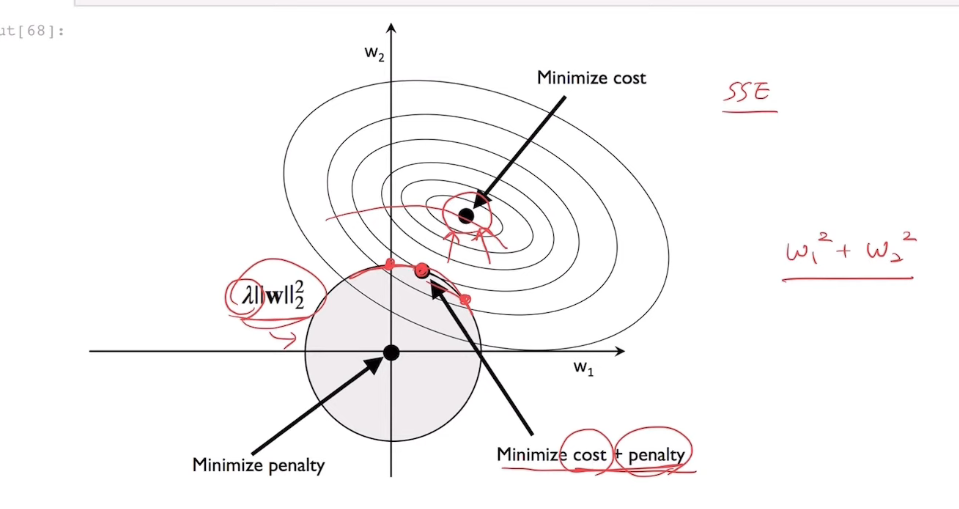

규제 속에서 가장 최적 점과 가까운곳을 찾는다

## 4.5.3 L1 규제를 사용한 희소성

w1은 사용이 되지 않게된다

In [ ]:
Image(url='https://git.io/JtY8t', width=500)

사이킷런에서 L1 규제를 지원하는 모델은 `penalty` 매개변수를 `l1`으로 지정하여 희소한 모델을 만들 수 있습니다:

In [ ]:
from sklearn.linear_model import LogisticRegression
LogisticRegression(penalty='l1', solver='liblinear')

LogisticRegression(penalty='l1', solver='liblinear')

표준화 전처리된 Wine 데이터에 적용해 보죠.

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l1', C=1.0, solver='liblinear', random_state=1)
# C=1.0이 기본입니다.
# 규제 효과를 높이거나 낮추려면 C 값을 증가시키거나 감소시킵니다.
lr.fit(X_train_std, y_train)
print('훈련 정확도:', lr.score(X_train_std, y_train))
print('테스트 정확도:', lr.score(X_test_std, y_test))

훈련 정확도: 1.0
테스트 정확도: 1.0


In [ ]:
lr.intercept_

array([-1.26392152, -1.21596534, -2.37040177])

In [ ]:
lr.coef_[lr.coef_!=0].shape

(23,)

In [ ]:
lr.coef_

array([[ 1.24567209,  0.18072301,  0.74682115, -1.16438451,  0.        ,
         0.        ,  1.1595535 ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.55864751,  2.50891241],
       [-1.53644846, -0.38769843, -0.99485417,  0.36489012, -0.05989298,
         0.        ,  0.66853184,  0.        ,  0.        , -1.93460212,
         1.23246414,  0.        , -2.23212696],
       [ 0.1355558 ,  0.16880291,  0.35718019,  0.        ,  0.        ,
         0.        , -2.43768478,  0.        ,  0.        ,  1.5635432 ,
        -0.81834553, -0.4930494 ,  0.        ]])

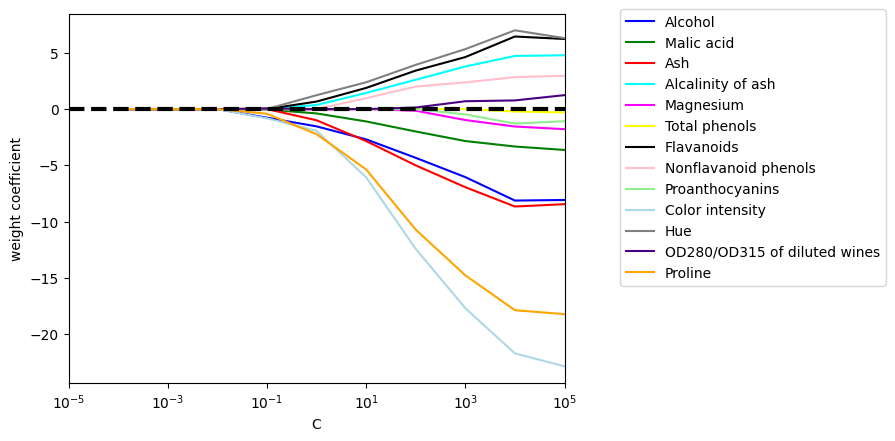

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot(111)

colors = ['blue', 'green', 'red', 'cyan',
          'magenta', 'yellow', 'black',
          'pink', 'lightgreen', 'lightblue',
          'gray', 'indigo', 'orange']

weights, params = [], []
for c in np.arange(-4., 6.):
    lr = LogisticRegression(penalty='l1', C=10.**c, solver='liblinear',
                            multi_class='ovr', random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)

weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
             label=df_wine.columns[column + 1],
             color=color)
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center',
          bbox_to_anchor=(1.38, 1.03),
          ncol=1, fancybox=True)
# plt.savefig('images/04_07.png', dpi=300,
#             bbox_inches='tight', pad_inches=0.2)
plt.show()

<br>

## 4.5.4 순차 특성 선택 알고리즘

In [ ]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):

        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train,
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train,
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

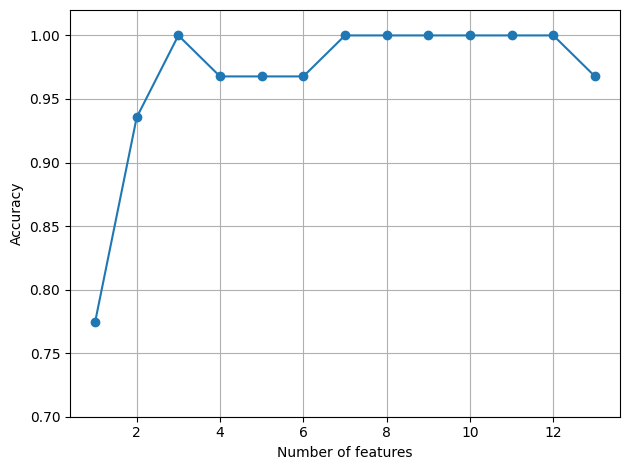

In [ ]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

# 특성을 선택합니다
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

# 선택한 특성의 성능을 출력합니다
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('images/04_08.png', dpi=300)
plt.show()

In [ ]:
k3 = list(sbs.subsets_[10])
print(df_wine.columns[1:][k3])

Index(['Alcohol', 'Malic acid', 'OD280/OD315 of diluted wines'], dtype='object')


In [ ]:
knn.fit(X_train_std, y_train)
print('훈련 정확도:', knn.score(X_train_std, y_train))
print('테스트 정확도:', knn.score(X_test_std, y_test))

훈련 정확도: 0.967741935483871
테스트 정확도: 0.9629629629629629


In [ ]:
knn.fit(X_train_std[:, k3], y_train)
print('훈련 정확도:', knn.score(X_train_std[:, k3], y_train))
print('테스트 정확도:', knn.score(X_test_std[:, k3], y_test))

훈련 정확도: 0.9516129032258065
테스트 정확도: 0.9259259259259259


<br>

# 4.6 랜덤 포레스트의 특성 중요도 사용

 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529
 6) Hue                            0.058739
 7) Total phenols                  0.050872
 8) Magnesium                      0.031357
 9) Malic acid                     0.025648
10) Proanthocyanins                0.025570
11) Alcalinity of ash              0.022366
12) Nonflavanoid phenols           0.013354
13) Ash                            0.013279


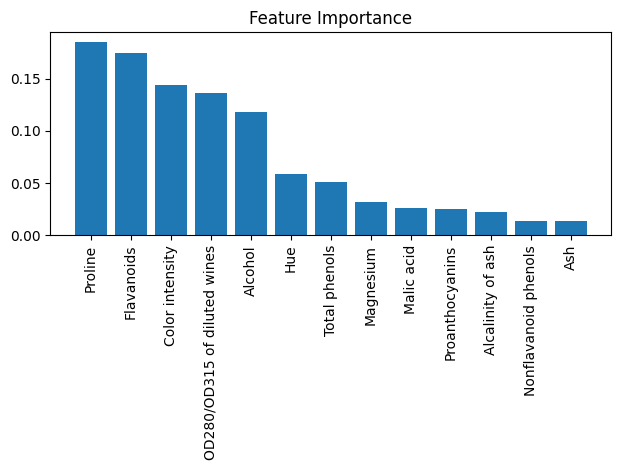

In [ ]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = df_wine.columns[1:]

forest = RandomForestClassifier(n_estimators=500,
                                random_state=1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[indices[f]],
                            importances[indices[f]]))

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]),
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]),
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
# plt.savefig('images/04_09.png', dpi=300)
plt.show()

변수 선택시 permutation importances 가 더좋다

In [ ]:
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(forest, threshold=0.1, prefit=True)
X_selected = sfm.transform(X_train)
print('이 임계 조건을 만족하는 샘플의 수:',
      X_selected.shape[1])

이 임계 조건을 만족하는 샘플의 수: 5


앞서 지정한 특성 선택 임계 조건에 맞는 특성 5개를 출력해 보겠습니다:

In [ ]:
for f in range(X_selected.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[indices[f]],
                            importances[indices[f]]))

 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529


`RFE`는 재귀적 특성 제거 방법을 사용합니다. 처음에 모든 특성을 사용해 모델을 만들고 특성 중요도가 가장 낮은 특성을 제거합니다. 그다음 제외된 특성을 빼고 나머지 특성으로 새로운 모델을 만듭니다. 이런 식으로 미리 정의한 특성 개수가 남을 때까지 계속합니다.

`RFE` 클래스의 `n_features_to_select` 매개변수에 선택할 특성의 개수를 지정합니다. 사이킷런 0.24 버전부터 [0, 1] 범위의 실수를 지정하여 선택할 특성의 비율을 지정할 수도 있습니다. 기본값은 입력 특성 개수의 절반입니다.

`step` 매개변수에서 각 반복에서 제거할 특성의 개수를 지정합니다. (0, 1) 사이의 값을 지정하면 삭제할 특성의 비율이 됩니다. 기본값은 1입니다.

기본적으로 기반 모델의 `coef_`나 `feature_importances_` 속성을 기준으로 특성을 제거합니다. 사이킷런 0.24 버전에서 사용할 속성을 지정할 수 있는 `importance_getter` 매개변수가 추가되었습니다.

`SelectFromModel`과 비교하기 위해 5개의 특성을 골라 보겠습니다.

In [ ]:
from sklearn.feature_selection import RFE

rfe = RFE(forest, n_features_to_select=5)
rfe.fit(X_train, y_train)

RFE(estimator=RandomForestClassifier(n_estimators=500, random_state=1),
    n_features_to_select=5)

`ranking_` 속성에는 선택한 특성의 우선순위가 들어있습니다. 1은 기반 모델이 선택한 5개 특성입니다.

In [ ]:
rfe.ranking_

array([1, 5, 9, 6, 4, 3, 1, 8, 7, 1, 2, 1, 1])

선택된 특성은 `support_` 속성에 `True`로 표시됩니다. 이 값을 `f_mask`로 저장하여 특성의 이름을 표시하는데 사용하겠습니다.

In [ ]:
f_mask = rfe.support_

훈련된 기반 모델(랜덤 포레스트)은 `estimator_` 속성에 저장되어 있습니다. 이 모델은 `n_features_to_select`개의 특성을 사용하여 훈련되어 있습니다. 이 모델의 특성 중요도를 저장하여 앞에서와 같이 중요도 순서대로 출력해 보겠습니다.

In [ ]:
importances = rfe.estimator_.feature_importances_
indices = np.argsort(importances)[::-1]

기반 모델을 동일한 랜덤 포레스로 사용했기 때문에 `SelectFromModel` 클래스로 선택한 특성과 순서가 약간 바뀌었을 뿐 동일합니다.

In [ ]:
for i in indices:
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[f_mask][i],
                            importances[i]))

 5) Proline                        0.261512
 5) Color intensity                0.216477
 5) Flavanoids                     0.212259
 5) OD280/OD315 of diluted wines   0.188924
 5) Alcohol                        0.120828


<br>